# Gassmann Fluid Substitution Workflow

## Introduction

This Python Jupyter notebook provides a simple step by step implementation of the Gassmann fluid substitution equations for porous media.

This specific version of the notebook has the following features:
- Homogenous saturation estimation 
- Basic modelling for CO2 replacing water
- Parameters based on Groningen Rotliegend averages
- Empirical Brie average has also been added for a patchy estimation and can be controlled by the 'e' parameter
- Graphical display output
- Attribute output to an ascii comma separated variable file. 

Gassmann Assumptions
- Rock is homogenous and isotropic
- Pore space is completely connected and saturated
- Pore pressures are equilibrated throughout the pore space

Disclaimer
- This is test code
- Please report any issues to christopher.willacy@shell.com

--------------------------------------------------------------------------------------------------------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Start with the measured density and velocities or the rock:

In [2]:
# initial rock conditions
Vp = 3.9  # Vp velocity in km/s
Vs = 2.286  # Vs velocity in km/s
rho = 2.46  # density of reservoir in g/cm3
Por = 0.2    # porosity fraction
K_min = 36.6 # matrix bulk modulus in GPa (assuming pure quartz matrix for sandstone)
Rho_quartz = 2.66 # quartz density g/cm3

# initial fluid conditions
Swe = 0.0      # gas saturation fraction
K_gas = 0.040108       # gas bulk modulus in GPa
K_wat = 3.68     # water bulk modulus in GPa
rho_gas = 0.41810  # density of gas in g/cm3
rho_wat = 1.17  # density of water in g/cm3

# power for Brie upper bound.  1 is equal to the Voigt lower bound. 
e = 1  

## 2. Extract elastic moduli of the rock:

## $p = -K \frac{\Delta V}{V} $

## $K = \rho_{B}(V_{P}^{2} - \frac{4}{3}V_{S}^{2}) $

## $\tau = \mu.\epsilon $

## $\mu = \rho_{B}V_{S}^{2} $

In [3]:
def k_init_moduli(rho,Vp,Vs):
    K_init_sat = rho * (Vp**2 - (4/3)*(Vs**2)) # bulk modulus before substitution 
    mu = rho * Vs**2 # shear modulus 
    return K_init_sat, mu

In [4]:
calc_moduli = k_init_moduli(rho,Vp,Vs)
K_init_sat = calc_moduli[0]
mu = calc_moduli[1]

In [5]:
print('--> Bulk modulus for the initial rock =',K_init_sat)
print('--> Shear modulus for the initial rock =',mu)

--> Bulk modulus for the initial rock = 20.27598912
--> Shear modulus for the initial rock = 12.85545816


## 3. Compute effective fluid properties:
- Bulk modulus and density of the saturating fluid is estimated
- May be a mixture of different fluids e.g. water and oil

## $K_{fl}^{init}=\frac{1}{\frac{S_{we}}{K_{wat}}+\frac{(1-S_{we})}{K_{oil}}}  $

## $\mu=\rho V_{S}^{2} $

In [6]:
def k_init_fluid(Swe,K_gas,K_wat,rho_gas,rho_wat):
    K_init_fluid = 1 / ((Swe/K_gas) + ((1-Swe) / K_wat)) 
    rho_init_fluid = Swe*rho_gas + (1-Swe)*rho_wat 
    return K_init_fluid, rho_init_fluid
    

In [7]:
calc_init_fluid = k_init_fluid(Swe,K_gas,K_wat,rho_gas,rho_wat)
K_init_fluid = calc_init_fluid[0]
Rho_init_fluid = calc_init_fluid[1]

In [8]:
print('--> Bulk modulus for the initial fluid state (GPa) =',K_init_fluid)
print('--> Shear modulus for th initial fluid state (GPa) =',Rho_init_fluid)

--> Bulk modulus for the initial fluid state (GPa) = 3.68
--> Shear modulus for th initial fluid state (GPa) = 1.17


## 4. Transform the moduli from the initial fluid saturation to the dry state:
- The dry state is the rock without any fluid inside
- Low-freqeuncy, drained bulk modulus of the rock
- Approximately the bulk modulus of an air-filled rock at standard pressure and temperature

## $K_{dry} = \frac{K_{sat}(\frac{\phi.K_{min}}{K_{fl}}+1-\phi)-K_{min}}{\frac{\phi.K_{min}}{K_{fl}}+\frac{K_{sat}}{K_{min}}-1-\phi}  $ 

In [9]:
def k_dry(K_init_sat,Por,K_min,K_init_fluid):
    K_dry = (K_init_sat * ( ( (Por*K_min) / K_init_fluid) + (1-Por)) - K_min) / \
        ( ( (Por*K_min) / K_init_fluid) + (K_init_sat/K_min) - 1 - Por)
    return K_dry

In [10]:
K_dry = k_dry(K_init_sat,Por,K_min,K_init_fluid)

In [11]:
print('--> Dry bulk modulus of the rock (GPa) =',K_dry)

--> Dry bulk modulus of the rock (GPa) = 14.855255008531298


## 5. Calculate new fluid properties:

In [12]:
def new_fluid(Swe,K_gas,K_wat,rho_gas,rho_wat):
    K_final_fluid = K_gas
    Rho_final_fluid = rho_gas

    return K_final_fluid, Rho_final_fluid

In [13]:
calc_new_fluid = new_fluid(Swe,K_gas,K_wat,rho_gas,rho_wat)
K_final_fluid = calc_new_fluid[0]
Rho_final_fluid = calc_new_fluid[1]

In [14]:
print('--> New fluid bulk modulus (GPa) =',K_final_fluid)
print('--> New fluid density (g/cm3) =',Rho_final_fluid)

--> New fluid bulk modulus (GPa) = 0.040108
--> New fluid density (g/cm3) = 0.4181


## 6. Transform from the dry moduli to the new fluid saturated state:

In [15]:
def k_final_sat(K_dry,K_min,Por,K_final_fluid):
    K_final_sat = K_dry + ( (1 - K_dry/K_min)**2 / \
                        ( (Por / K_final_fluid) + ((1 - Por) / K_min) - (K_dry / K_min**2) ) )
    return K_final_sat

In [16]:
K_final_sat = k_final_sat(K_dry,K_min,Por,K_final_fluid)

In [17]:
print('--> Substituted bulk modulus (GPa) =',K_final_sat)

--> Substituted bulk modulus (GPa) = 14.92588849495806


## 7. Shear modulus is unchanged:

In [18]:
mu = rho * Vs**2 # shear modulus is unchanged according to Gassmann

In [19]:
print('--> Shear modulus after substitution remains the same =',mu)

--> Shear modulus after substitution remains the same = 12.85545816


## 8. Transform density:

In [20]:
def update_density(Rho_quartz,Por,Rho_final_fluid):
    Rho_final = Rho_quartz * (1-Por) + Rho_final_fluid * Por
    return Rho_final

In [21]:
Rho_final = update_density(Rho_quartz,Por,Rho_final_fluid)

In [22]:
print('--> New density =',Rho_final)

--> New density = 2.21162


## 9. Compute the new velocities:

## $V_P = \sqrt{\frac{K + \frac{4}{3}\mu}{\rho}} $

## $V_S = \sqrt{\frac{\mu}{\rho}} $

In [23]:
Vs_new = np.sqrt(mu/Rho_final)
Vp_new = np.sqrt((K_final_sat + ((4/3)*mu)) / Rho_final)

In [24]:
print('--> New Vs Velocity =',Vs_new)
print('--> New Vp Velocity =',Vp_new)

--> New Vs Velocity = 2.410951784850922
--> New Vp Velocity = 3.8077683653907806


## 10. Calculate some additional metrics:

In [25]:
#----------------------------------------------------------------
# calculate P-Wave difference
#----------------------------------------------------------------
def vpdelta(Vp,Vp_new):
    diff = Vp_new - Vp
    return np.round(diff, 6)

In [26]:
vp_delta = vpdelta(Vp, Vp_new)

In [27]:
#----------------------------------------------------------------
# calculate S-Wave difference
#----------------------------------------------------------------
def vsdelta(Vs,Vs_new):
    diff = Vs_new - Vs
    return np.round(diff, 6)

In [28]:
vs_delta = vsdelta(Vs, Vs_new)

In [29]:
#----------------------------------------------------------------
# calculate percentage change
#----------------------------------------------------------------
def pchange(x1,x2):
    # x1 original value
    # x2 new value
    C = ((x2-x1)/x1)*100
    return np.round(C, 6)

In [30]:
velp = pchange(Vp,Vp_new)

In [31]:
#----------------------------------------------------------------
# calculate impedance
#----------------------------------------------------------------
def impedance(vel,den):
    imp = vel * den
    return np.round(imp, 6)

In [32]:
impedance_before = impedance(Vp,rho)
impedance_after = impedance(Vp_new,Rho_final)
impedance_delta = np.round(impedance_after - impedance_before,3)

## 11.  Results Summary:

In [33]:
print('--> Vp velocity (km/s) =',np.round(Vp,4),'->',np.round(Vp_new,4))
print('--> Vs velocity (km/s) =',np.round(Vs,4),'->',np.round(Vs_new,4))
print('--> Vp velocity difference (m/s) =',np.round(vp_delta*1000,4))
print('--> Vs velocity difference (m/s) =',vs_delta*1000)
print('--> Vp velocity change (%) =',velp)
print('--> Density (g/cm3) =',rho,'->',Rho_final)
print('--> Impedance Delta =',impedance_delta)

--> Vp velocity (km/s) = 3.9 -> 3.8078
--> Vs velocity (km/s) = 2.286 -> 2.411
--> Vp velocity difference (m/s) = -92.232
--> Vs velocity difference (m/s) = 124.952
--> Vp velocity change (%) = -2.364914
--> Density (g/cm3) = 2.46 -> 2.21162
--> Impedance Delta = -1.173


## 12. Loop over workflow and vary the saturation:

In [34]:
def new_fluid_vary(Swe,K_gas,K_wat,rho_gas,rho_wat):
    K_final_fluid = 1 / ((Swe/K_gas) + ((1-Swe) / K_wat))    
    Rho_final_fluid = Swe*rho_gas + (1-Swe)*rho_wat 
    return K_final_fluid, Rho_final_fluid

In [35]:
def brie_fluid_vary(Swe,K_gas,K_wat,e):
    K_brie_fluid = (K_wat - K_gas) * (1 - Swe)**e + K_gas    
    return K_brie_fluid

In [36]:
x = []
y = []
y2 = []
y3 = []
y4 = []
y5 = []
y6 = []
y7 = []
y8 = []
y9 = []
y10 = []
vp_start = 0
rho_start = 0

for i in range (0,101,1):
   
    # water saturation fraction 
    Swe = i * 0.01  
    
    # calculate the new fluid properties
    calc_new_fluid = new_fluid_vary(Swe,K_gas,K_wat,rho_gas,rho_wat)
    K_final_fluid = calc_new_fluid[0]
    Rho_final_fluid = calc_new_fluid[1]
    brie_fluid = brie_fluid_vary(Swe,K_gas,K_wat,e)
    
    # calculate the final modulus after substitution
    K_final_sat = k_final_sat(K_dry,K_min,Por,K_final_fluid)   
    K_final_brie_sat = k_final_sat(K_dry,K_min,Por,brie_fluid)
    
    # update the density with the new fluid change
    Rho_final = update_density(Rho_quartz,Por,Rho_final_fluid)
    
    # calculate the new velocities
    Vs_new = np.sqrt(mu/Rho_final)
    Vp_new = np.sqrt((K_final_sat + ((4/3)*mu)) / Rho_final)
    Vp_brie_new = np.sqrt((K_final_brie_sat + ((4/3)*mu)) / Rho_final)
    vp_delta = vpdelta(Vp, Vp_new)
    
    # calculate impedance change from orginal rock        
    if i == 0:
        vp_start=Vp_new
        rho_start=Rho_final
        
    impedance_before = impedance(vp_start,rho_start)   
    impedance_after = impedance(Vp_new,Rho_final)
    impedance_after_brie = impedance(Vp_brie_new,Rho_final)
    
    #impedance_delta = np.round(impedance_after - impedance_before,3)    
    impedance_delta = pchange(impedance_before,impedance_after)
    impedance_delta_brie = pchange(impedance_before,impedance_after_brie)
    
    x.append(Swe*100)
    #y.append(np.round(Vp_new*1000,6)) 

    y.append(Vp_new)
    #y2.append(np.round(Vs_new*1000,6))
    y2.append(Vs_new)
    y3.append(Rho_final)
    y4.append(impedance_delta)
    y5.append(Vp_brie_new)
    y6.append(Rho_final_fluid)
    y7.append(K_final_fluid)
    y8.append(K_final_sat)
    y9.append(mu) 
    y10.append(impedance_delta_brie)

### Display results

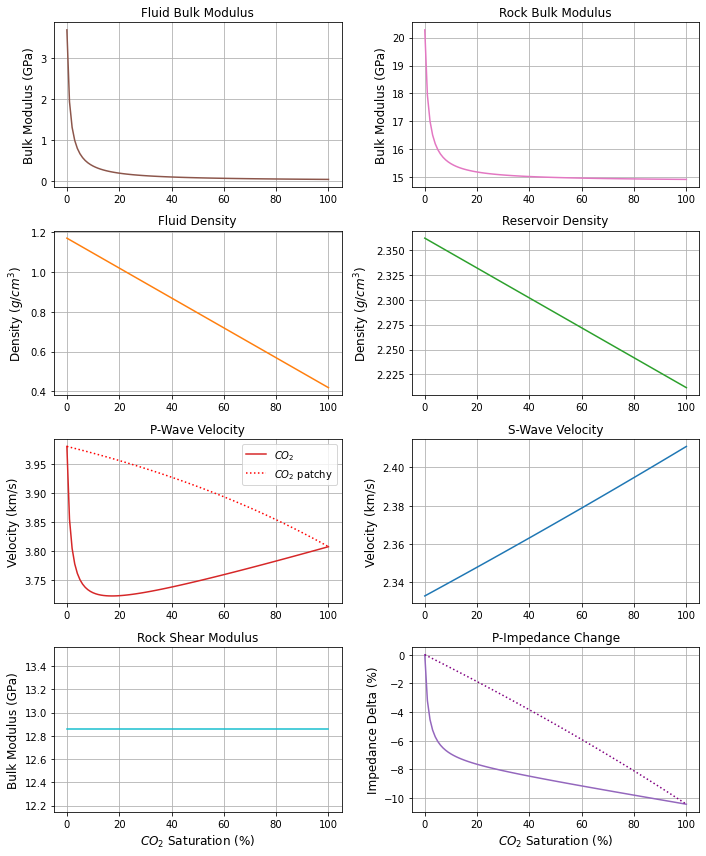

In [37]:
fig, axs = plt.subplots(4, 2, figsize=(10,12))

axs[0, 0].plot(x, y7, 'tab:brown')
axs[0, 0].set_title('Fluid Bulk Modulus', fontsize=12)
axs[0, 0].set_ylabel(r'Bulk Modulus (GPa)', fontsize=12)
axs[0, 0].grid(True)

axs[0, 1].plot(x, y8, 'tab:pink')
axs[0, 1].set_title('Rock Bulk Modulus', fontsize=12)
axs[0, 1].set_ylabel(r'Bulk Modulus (GPa)', fontsize=12)
axs[0, 1].grid(True)

axs[1, 0].plot(x, y6, 'tab:orange')
axs[1, 0].set_title('Fluid Density', fontsize=12)
axs[1, 0].set_ylabel(r'Density ($g/cm^3$)', fontsize=12)
#axs[1, 0].set_ylim(0.0,1.2)
axs[1, 0].grid(True)

axs[1, 1].plot(x, y3, 'tab:green')
axs[1, 1].set_title('Reservoir Density', fontsize=12)
axs[1, 1].set_ylabel(r'Density ($g/cm^3$)', fontsize=12)
#axs[1, 1].set_ylim(2.0,2.4)
axs[1, 1].grid(True)

axs[2, 0].plot(x, y, 'tab:red', label=r'$CO_2$')
axs[2, 0].plot(x, y5, color='red', label=r'$CO_2$ patchy', linestyle=':')
axs[2, 0].set_title('P-Wave Velocity', fontsize=12)
axs[2, 0].set_ylabel('Velocity (km/s)', fontsize=12)
#axs[2, 0].set_ylim(3.8,4.1)
axs[2, 0].grid(True)
axs[2, 0].legend()

axs[2, 1].plot(x, y2, 'tab:blue')
axs[2, 1].set_title('S-Wave Velocity', fontsize=12)
axs[2, 1].set_ylabel('Velocity (km/s)', fontsize=12)
#axs[2, 1].set_ylim(1,3)
axs[2, 1].grid(True)

axs[3, 0].plot(x, y9, 'tab:cyan')
axs[3, 0].set_title('Rock Shear Modulus', fontsize=12)
axs[3, 0].set_xlabel(r'$CO_2$ Saturation (%)', fontsize=12)
axs[3, 0].set_ylabel(r'Bulk Modulus (GPa)', fontsize=12)
axs[3, 0].grid(True)

axs[3, 1].plot(x, y4, 'tab:purple')
axs[3, 1].plot(x, y10, color='purple', label=r'$CO_2$ patchy', linestyle=':')
axs[3, 1].set_title('P-Impedance Change', fontsize=12)
axs[3, 1].set_xlabel(r'$CO_2$ Saturation (%)', fontsize=12)
axs[3, 1].set_ylabel('Impedance Delta (%)', fontsize=12)
#axs[3, 1].set_ylim(-15,0)
axs[3, 1].grid(True)


fig.tight_layout()

### Output some of the key values to a comma separated ascii file

In [38]:
f = open('gassman_output.csv', 'w')

length = len(x)

for i in range(0,length,1):
    
    f.write('{0:12.3f},{1:12.3f},{2:12.3f},{3:12.6f},{4:12.6f},{5:12.3f}\n'.format(x[i],y[i],y2[i],y3[i],y4[i],y5[i]))
                         
f.close() #close file

## References

Batzle, M. and Z. Wang, 1992, Seismic properties of pore fluids. Geophysics, vol. 57, no. 11, p1396 - 1408.

Lys, P. O., 2016, EAGE E-Lecture.  

Moradi, S. and D. C. Lawton, 2013, Time-lapse seismic modeling of CO2 sequestration at Quest CCS project. Geoconvention: Integration.

Simm, R., 2007, Practical Gassmann fluid substitution in sand/shale sequences. First Break, vol. 25.  Smith, T. M., C. H.  

Sodagar, T. M. and D. C. Lawton, 2011, Seismic modeling of CO2 fluid substitution for the Heartland Area Redwater CO2 Storage Project (HARP), Alberta, Canada. Energy Procedia, 4, p3338-3345.  

Sondergeld and C. S. Rai, 2003, Gassman fluid substitutions: A tutorial.  GEOPHYSICS, vol. 68, No. 2, p. 430-440, 10.1190/1.1567211.

## Author

Chris Willacy SUKEP-UPV/S/EP - christopher.willacy@shell.com